In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint


In [2]:
#constants
n_jobs = -1
random_state = 42
seed = 24

### Import Data Set

In [3]:
df = pd.read_csv('df_for_model.csv') #from 'Machine Learning - Preparation'
random_sample = df.sample(n=1000, random_state=random_state) #for validation
df = df.drop(random_sample.index)

In [4]:
df.head()

,DepDelay,Month,route,TaxiOut,TaxiIn,TimeDifferenceMinutes_wheels,Distance,ArrDelay
0,-3.0,12,LGA-DEN,38.0,8.0,103.0,1620.0,-9.0
1,-7.0,12,EWR-ORD,17.0,5.0,49.0,719.0,-20.0
2,-11.0,12,EWR-LAS,14.0,7.0,109.0,2227.0,-35.0
3,-6.0,12,SAN-ORD,15.0,14.0,332.0,1723.0,-6.0
4,-1.0,12,BOS-IAD,12.0,4.0,68.0,413.0,-12.0


### Split Data

In [5]:
columns_to_drop = ['ArrDelay']
X = df.drop(columns_to_drop, axis=1)
y = df['ArrDelay']
    
# Split the data
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y,
                                                              test_size=0.2,
                                                              random_state=random_state,
                                                              #stratify=X['ArrivalDelayGroups']
                                                             )


X_train, X_val, y_train, y_val = train_test_split(X_train_temp,
                                                  y_train_temp,
                                                  test_size=0.2,
                                                  random_state=random_state,
                                                  #stratify=X_train_temp['ArrivalDelayGroups']
                                                 )

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

X_train shape: (392905, 7)
X_test shape: (122783, 7)
X_val shape: (98227, 7)


### Transform Target Variable

In [6]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
def yj_transform(model, feature):
    f_trans = model.fit_transform(np.array(feature).reshape(-1, 1))
    return f_trans

y_train_trans = yj_transform(pt, y_train)
y_test_trans = yj_transform(pt, y_test)
y_val_trans = yj_transform(pt, y_val)

### Encode Categorical Features

In [38]:
def lab_encoder(df):
    df_copy = df.copy()
    label_encoder = LabelEncoder()
    # Separate numeric and object columns
    object_columns = df_copy.select_dtypes(exclude=[np.number]).columns.tolist()
    for c in object_columns:
        if df_copy[c].dtype == 'O':  # Check if the column is of object type
            df_copy[c] = label_encoder.fit_transform(df_copy[c])
    return df_copy

X_train = lab_encoder(X_train)
X_val = lab_encoder(X_val)
X_test = lab_encoder(X_test)

### Scale Features

In [8]:
# Scale the data to be between -1 and 1
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

### Learning Curve

In [61]:
from sklearn.model_selection import learning_curve 
from sklearn.metrics import make_scorer

def custom_scoring(y_true, y_pred):
    inversed_y_pred = pt.inverse_transform(y_pred.reshape(-1, 1))#inverse the prediction to original minutes scale
    r2 = r2_score(y_true, inversed_y_pred)
    return -r2

custom_scorer = make_scorer(custom_scoring)

sizes, training_scores, testing_scores = learning_curve(RandomForestRegressor(max_depth=100,
                                                                              min_samples_split=2,
                                                                              min_samples_leaf=1,
                                                                              max_features=4,
                                                                              bootstrap=False,
                                                                              n_estimators=176,
                                                                              random_state=random_state,
                                                                              n_jobs=n_jobs),
                                                        X_train_scaled, 
                                                        np.ravel(y_train_trans), 
                                                        cv=5,
                                                        scoring=custom_scorer,
                                                        train_sizes=np.linspace(0.01, 1.0, 10)) 
  

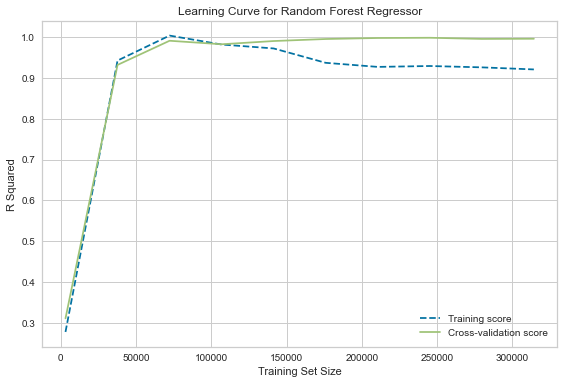

In [62]:
# Mean and Standard Deviation of training scores 
mean_training = np.mean(training_scores, axis=1) 
std_training = np.std(training_scores, axis=1) 
  
# Mean and Standard Deviation of testing scores 
mean_testing = np.mean(testing_scores, axis=1) 
std_testing = np.std(testing_scores, axis=1) 
  
# dotted blue line is for training scores and green line is for cross-validation score 
plt.plot(sizes, mean_training, '--', color="b",  label="Training score") 
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score") 
  
# Drawing plot 
plt.title("Learning Curve for Random Forest Regressor") 
plt.xlabel("Training Set Size"), plt.ylabel("R Squared"), plt.legend(loc="best") 
plt.tight_layout() 
plt.show()



### Grid Search

In [33]:
'''
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 9)]
# Number of features to consider at every split
max_features = [2,4,6]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 10,
                               cv = 3,
                               verbose=2,
                               random_state=random_state,
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_scaled, y_train)

rf_random.best_params_
'''

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': [2, 4, 6],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 33, 57, 81, 105, 128, 152, 176, 200]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'n_estimators': 176,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 4,
 'max_depth': 100,
 'bootstrap': False}

In [ ]:
best_param = rf_random.best_params_

### Train Model

In [9]:
rf = RandomForestRegressor(max_depth=100,
                           min_samples_split=2,
                           min_samples_leaf=1,
                           max_features=4,
                           bootstrap=False,
                           n_estimators=176,
                           random_state=random_state,
                           n_jobs=n_jobs)

# Fitting the Random Forest Regression model to the data
rf.fit(X_train_scaled, np.ravel(y_train_trans))

RandomForestRegressor(bootstrap=False, max_depth=100, max_features=4,
                      n_estimators=176, n_jobs=-1, random_state=42)

### Predict Test Set

In [13]:
#predict data set
def predict_data(model,test_data):
    pred = model.predict(test_data)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    inversed_pred = pt.inverse_transform(pred.reshape(-1, 1))#inverse the prediction to original minutes scale
    return inversed_pred

In [11]:
#print out the predition validation results
def prediction_results(original_value, inversed_prediction):
    print(f"MAE: {mean_absolute_error(original_value, inversed_prediction):.2f}")
    print(f"MSE: {mean_squared_error(original_value, inversed_prediction):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(original_value, inversed_prediction)):.2f}")
    print(f"R-squared: {r2_score(original_value, inversed_prediction):.2f}")

In [14]:
test_pred_org = predict_data(rf, X_test_scaled)
prediction_results(y_test, test_pred_org)

MAE: 6.35
MSE: 80.66
RMSE: 8.98
R-squared: 0.97


### Predict Validation Set

In [17]:
val_pred_org = predict_data(rf, X_val_scaled)
prediction_results(y_val, val_pred_org)

MAE: 6.32
MSE: 78.48
RMSE: 8.86
R-squared: 0.97


### Feature Importance

                        Feature  Importance
0                      DepDelay    0.512868
3                       TaxiOut    0.139152
5  TimeDifferenceMinutes_wheels    0.106260
6                      Distance    0.076277
4                        TaxiIn    0.062112
2                         route    0.057249
1                         Month    0.046082


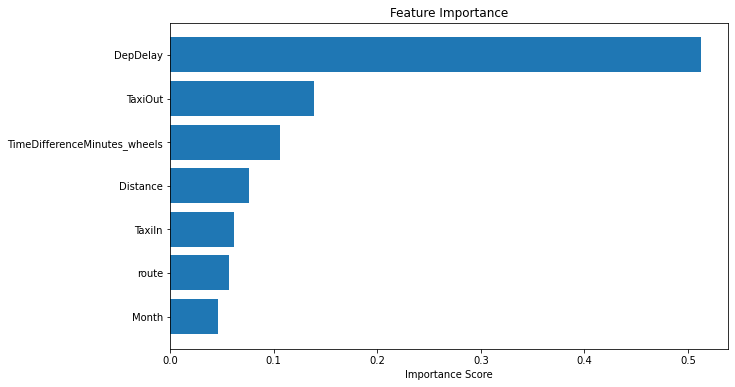

In [18]:
# Extract feature importance scores
feature_importance = rf.feature_importances_

# Create a DataFrame to organize feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or display the feature importance DataFrame
print(feature_importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][::-1], feature_importance_df['Importance'][::-1])
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.show()

### Validation Charts

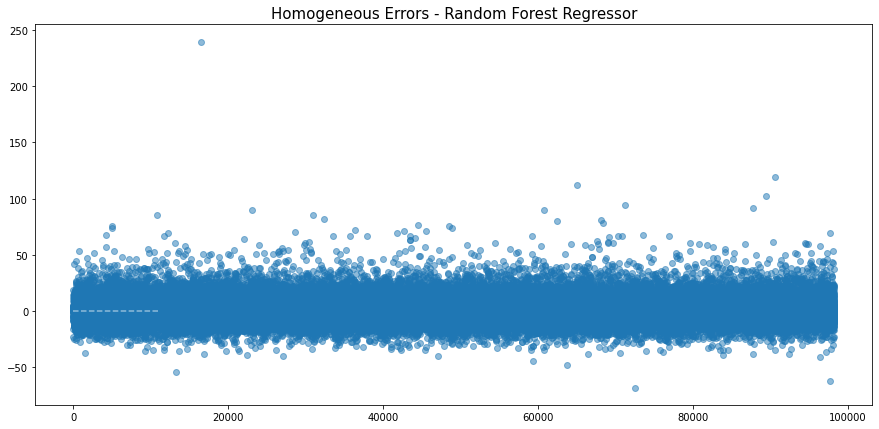

In [19]:
performance = pd.DataFrame({'True Value': y_val,
                            'Prediction': val_pred_org.flatten(),
                            'Error': y_val-val_pred_org.flatten()})

plt.figure(figsize=(15,7))
# Errors
ax_x= performance['True Value']
ax_y= performance['Prediction']
yerr= performance['Error']

plt.scatter(range(len(yerr)), yerr, alpha=.5)
plt.title('Homogeneous Errors - Random Forest Regressor', size=15);
plt.hlines(y=0, xmin=0, xmax=11000, linestyle='--', color='white', alpha=.5);

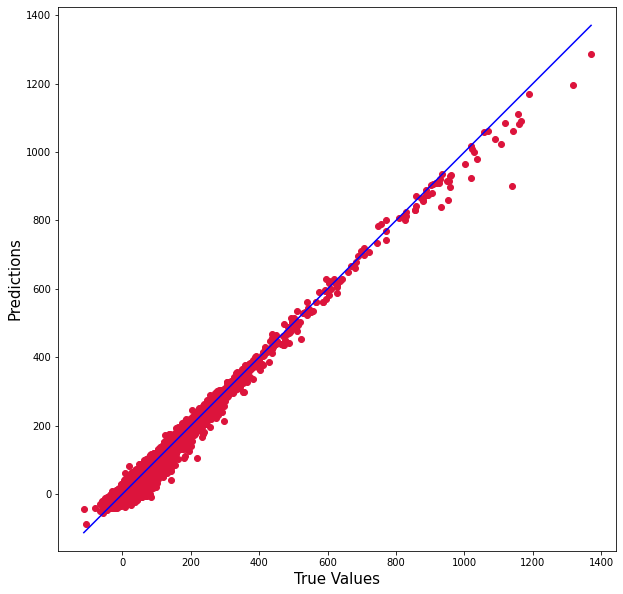

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(y_val, val_pred_org.flatten(), c='crimson')


p1 = max(max(val_pred_org), max(y_val))
p2 = min(min(val_pred_org), min(y_val))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

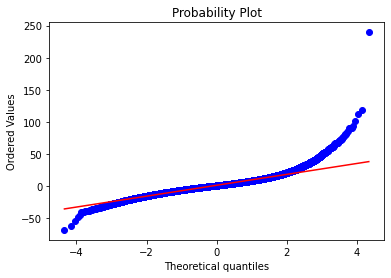

In [21]:
from scipy.stats import probplot
#QQ Plot
probplot(yerr, dist='norm', plot=plt);


### Prediction on Random Data Samples

In [23]:
X_sample = random_sample.drop(columns_to_drop, axis=1)
y_sample = random_sample['ArrDelay']
X_sample = lab_encoder(X_sample)
X_sample_scaled = scaler.transform(X_sample)

In [24]:
sample_pred_org = predict_data(rf, X_sample_scaled)
prediction_results(y_sample, sample_pred_org)

MAE: 6.88
MSE: 85.58
RMSE: 9.25
R-squared: 0.96


<div style="float: left; margin-right: 10px;">

Test Results				
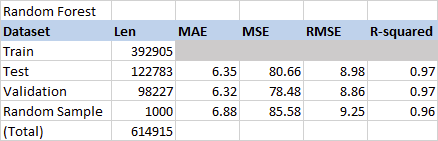
</div>

In [63]:
import pickle
#pickle.dump(rf, open('rf_model', 'wb'))
#pickle.dump(pt, open('pt_model', 'wb'))

In [29]:
#loaded_model = pickle.load(open('rf_model', 'rb'))

### Prediction on 2019's Dataset

In [44]:
#read 2019's data
ua_2019 = pd.read_csv('ua_2019.csv')
#remove cancelled and diverted records
ua_2019 = ua_2019[(ua_2019['Cancelled']==0) & (ua_2019['Diverted']==0)]
#concatanate Origin and Dest
ua_2019['route'] = ua_2019['Origin'] + '-' + ua_2019['Dest']

In [45]:
# Add leading 0s if it is less than 4 digits
ua_2019['WheelsOff_time'] = ua_2019['WheelsOff'].apply(lambda x: f'{x // 100:02d}:{x % 100:02d}')
ua_2019['WheelsOn_time'] = ua_2019['WheelsOn'].apply(lambda x: f'{x // 100:02d}:{x % 100:02d}')

# Convert the three or four digits to 'hh:mm' format
ua_2019['WheelsOff_time'] = pd.to_datetime(ua_2019['WheelsOff_time'], format='%H:%M')
ua_2019['WheelsOn_time'] = pd.to_datetime(ua_2019['WheelsOn_time'], format='%H:%M')
   
# Calculate the time difference in minutes
ua_2019['TimeDifferenceMinutes_wheels'] = (ua_2019['WheelsOn_time'] - ua_2019['WheelsOff_time']).dt.total_seconds() / 60
ua_2019['TimeDifferenceMinutes_wheels'] = ua_2019['TimeDifferenceMinutes_wheels'].apply(lambda x: x + 24 * 60 if x < 0 else x)

In [46]:
# Define X and y
X_ua_2019 = ua_2019[X_train.columns.tolist()]
y_ua_2019 = ua_2019['ArrDelay']
X_ua_2019 = lab_encoder(X_ua_2019)

In [49]:
#Scale data
X_ua_2019_scaled = scaler.transform(X_ua_2019)

In [50]:
# Predict data and print out prediction results
ua_2019_pred_org = predict_data(rf, X_ua_2019_scaled)
prediction_results(y_ua_2019, ua_2019_pred_org)

MAE: 7.25
MSE: 101.67
RMSE: 10.08
R-squared: 0.97


https://www.geeksforgeeks.org/using-learning-curves-ml/

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74v

https://sikflow.io/projects/grid-random